第四章讲的 李群和李代数

简单的理解 旋转矩阵 组成的集合就是一个李群

李群具有连续，没有奇点 等的利于分析性质
但是李群的表示不方便，李代数就是李群的切空间，可以用来表示李群

李代数的定义
李代数是一个向量空间，同时还有一个二元运算，满足
1. 闭合性
2. 结合律
3. 分配律
4. 存在单位元
5. 存在逆元

李代数的例子
1. 旋转矩阵的李代数
2. 旋转矩阵的李代数的对偶空间
3. 李代数的矩阵表示
4. 李代数的对称矩阵表示
5. 李代数的反对称

李代数和李群是可以通过指数映射和对数映射相互转换的

所以在做slam的空间点坐标运算的时候会经常用到 李群李代数相关的转化 

转化的推导过程可以先忽略，看下面的图进行理解就可以了~
书上 P81
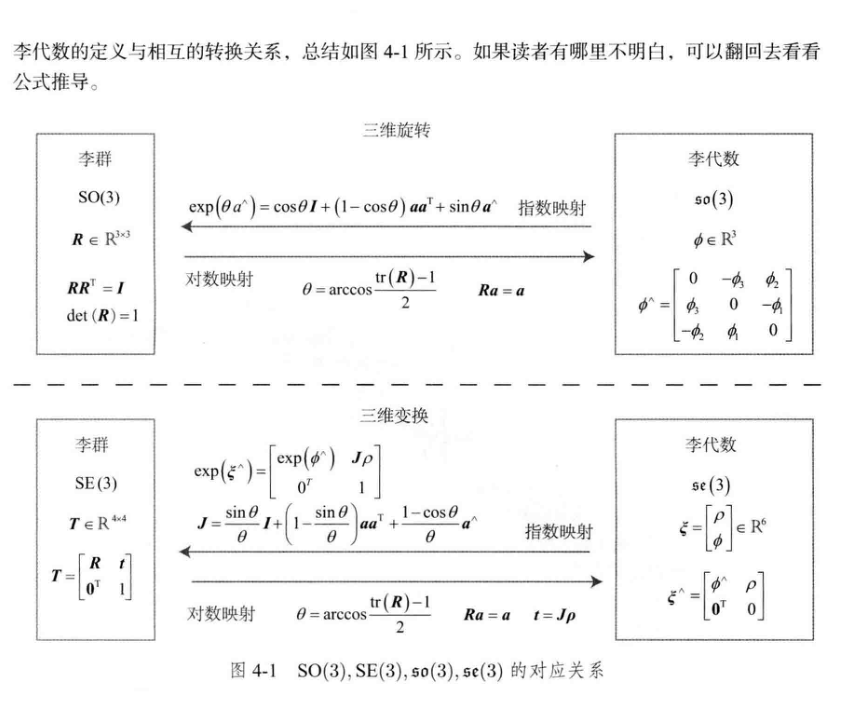


pip install numpy scipy liegroups

这里用的库 和c++中的不同，但是原理都是一样的，简单的说知道原理，计算交给库来处理


In [7]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def hat(v):
    """将3D向量转换为反对称矩阵"""
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def vee(m):
    """将反对称矩阵转换为3D向量"""
    return np.array([m[2, 1], m[0, 2], m[1, 0]])

def se3_hat(v):
    """将6D向量转换为se(3)矩阵"""
    omega = v[3:]
    u = v[:3]
    result = np.zeros((4, 4))
    result[:3, :3] = hat(omega)
    result[:3, 3] = u
    return result

def se3_vee(m):
    """将se(3)矩阵转换为6D向量"""
    return np.concatenate([m[:3, 3], vee(m[:3, :3])])

def main():
    # 沿Z轴转90度的旋转矩阵
    rot_matrix = R.from_rotvec([0, 0, np.pi/2]).as_matrix()
    
    SO3_R = R.from_matrix(rot_matrix)
    SO3_v = R.from_rotvec([0, 0, np.pi/2])
    q = SO3_R.as_quat()
    SO3_q = R.from_quat(q)
    
    print("SO(3) from matrix:\n", SO3_R.as_matrix())
    print("SO(3) from vector:\n", SO3_v.as_matrix())
    print("SO(3) from quaternion:\n", SO3_q.as_matrix())
    
    # 使用对数映射获得它的李代数
    so3 = SO3_R.as_rotvec()
    print("so3 =", so3)
    
    print("so3 hat=\n", hat(so3))
    print("so3 hat vee=", vee(hat(so3)))
    
    # 增量扰动模型的更新
    update_so3 = np.array([1e-4, 0, 0])
    SO3_updated = R.from_rotvec(update_so3) * SO3_R
    print("SO3 updated =\n", SO3_updated.as_matrix())
    
    print("************我是分割线*************")
    
    # 对SE(3)操作
    t = np.array([1, 0, 0])  # 沿X轴平移1
    SE3_Rt = np.eye(4)
    SE3_Rt[:3, :3] = rot_matrix
    SE3_Rt[:3, 3] = t
    
    SE3_qt = np.eye(4)
    SE3_qt[:3, :3] = SO3_q.as_matrix()
    SE3_qt[:3, 3] = t
    
    print("SE3 from R,t=\n", SE3_Rt)
    print("SE3 from q,t=\n", SE3_qt)
    
    # 李代数se(3) 是一个六维向量
    se3 = np.concatenate([t, so3])
    print("se3 =", se3)
    
    print("se3 hat =\n", se3_hat(se3))
    print("se3 hat vee =", se3_vee(se3_hat(se3)))
    
    # 最后，演示一下更新
    update_se3 = np.zeros(6)
    update_se3[0] = 1e-4
    update_matrix = np.eye(4)
    update_matrix[:3, :3] = R.from_rotvec(update_se3[3:]).as_matrix()
    update_matrix[:3, 3] = update_se3[:3]
    SE3_updated = update_matrix @ SE3_Rt
    print("SE3 updated =\n", SE3_updated)

if __name__ == "__main__":
    main()



SO(3) from matrix:
 [[ 3.33066907e-16 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  3.33066907e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
SO(3) from vector:
 [[ 2.22044605e-16 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
SO(3) from quaternion:
 [[ 3.33066907e-16 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  3.33066907e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
so3 = [0.         0.         1.57079633]
so3 hat=
 [[ 0.         -1.57079633  0.        ]
 [ 1.57079633  0.         -0.        ]
 [-0.          0.          0.        ]]
so3 hat vee= [0.         0.         1.57079633]
SO3 updated =
 [[ 3.33066907e-16 -1.00000000e+00 -6.77626358e-21]
 [ 9.99999995e-01  3.33066907e-16 -9.99999998e-05]
 [ 9.99999998e-05  2.71050543e-20  9.99999995e-01]]
************我是分割线*************
SE3 from R,t=
 [[ 2.22044605e-16 -1.00000000e+00  0.00000